# Cross-correlation

In [7]:
import numpy as np
import pandas as pd
import sqlite3
import skinematics as skin
import scipy 
import matplotlib.pyplot as plt
import os
import re

import functionsMasterProjectMeinhart as fmpm

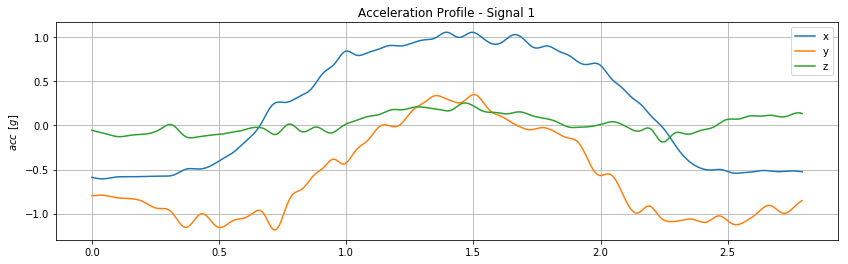

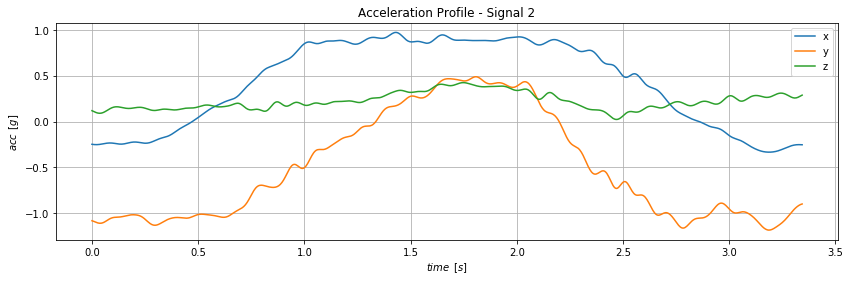

In [8]:
signals_1 = get_data_one_rep(subject_number=1,
                             exercise_abbreviation='TC',
                             number_repetitions=5,
                             sequence_number=1,
                             db_name='DataBase_Pysio.db',
                             csv_dir='E:\Physio_Data_Split_Exercise_done',
                             sampling_rate=256,
                             cutoff=10, 
                             order=6)
 
signals_2 = get_data_one_rep(subject_number=1,
                             exercise_abbreviation='TC',
                             number_repetitions=15,
                             sequence_number=15)

# plot the two sets of signals
fig1 = plt.figure(figsize=(14,4))
fmpm.plot_signal(signals_1['Acc'], time=signals_1['time'],
                 Title='Acceleration Profile - Signal 1', xLabel='')
fig2 = plt.figure(figsize=(14,4))
fmpm.plot_signal(signals_2['Acc'], time=signals_2['time'],
                 Title='Acceleration Profile - Signal 2')

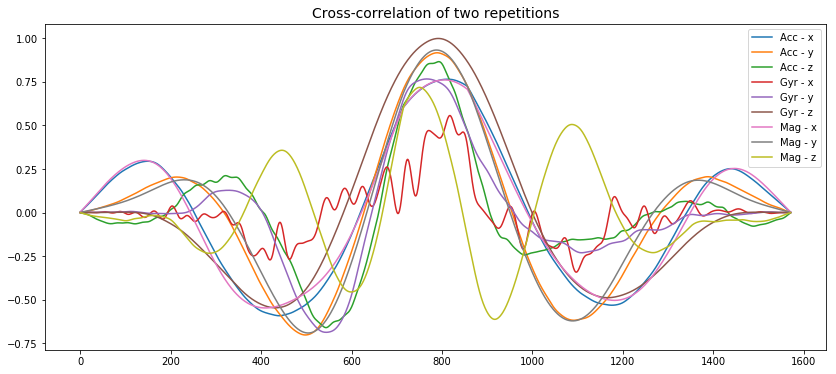

In [9]:
# do normalized cross-correlation for signals of two repetitions
fig = plt.figure(figsize=(14,6))
for sig in ['Acc', 'Gyr', 'Mag']:
    for ind, axis in zip([0,1,2], ['x','y','z']):
        corr = fmpm.norm_cross_corr(signals_1[sig][:,ind], signals_2[sig][:,ind], mode='full')
        plt.plot(corr, label= sig + ' - ' + axis);
        
plt.title('Cross-correlation of two repetitions', fontsize=14)
plt.legend(loc='upper right')
plt.show()

In [10]:
signals = signals_1

In [11]:
sampling_rate = 256

In [12]:
# split signals into sections and calculate average of of each section
num_sec = 20

# number of data points
len_data = np.shape(signals['time'])[0]

# get indices of the sections (+1 due to start and end index of each section)
sec_indices = np.linspace(0, len_data, num_sec+1)
sec_indices = [int(i) for i in sec_indices]
len(sec_indices)

21

In [13]:
# generate rows with three zeros in order to use np.vstack afterwards
sec_mean_acc = np.array([0,0,0])
sec_mean_gyr = np.array([0,0,0])
sec_mean_mag = np.array([0,0,0])

# add the mean of each section and signal
for ii in range(len(sec_indices)-1):
    sec_mean_acc = np.vstack((sec_mean_acc, np.mean(signals['Acc'][sec_indices[ii]:sec_indices[ii+1]], axis=0)))
    sec_mean_gyr = np.vstack((sec_mean_gyr, np.mean(signals['Gyr'][sec_indices[ii]:sec_indices[ii+1]], axis=0)))
    sec_mean_mag = np.vstack((sec_mean_mag, np.mean(signals['Mag'][sec_indices[ii]:sec_indices[ii+1]], axis=0)))

# delete the first row with the zeros
sec_mean_acc = np.delete(sec_mean_acc, 0, axis=0)
sec_mean_gyr = np.delete(sec_mean_gyr, 0, axis=0)
sec_mean_mag = np.delete(sec_mean_mag, 0, axis=0)

np.shape(sec_mean_acc)

(20, 3)

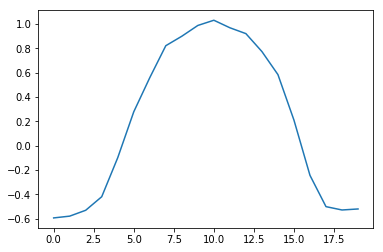

In [14]:
plt.plot(sec_mean_acc[:,0]);

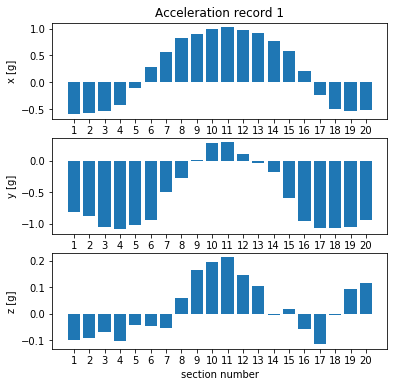

In [31]:
fig_acc1, axs_acc1 = plt.subplots(3,1,figsize=(6,6))

x_ticks = [str(i+1) for i in range(num_sec)]

axs_acc1[0].set_title('Acceleration record 1')
axs_acc1[2].set_xlabel('section number')

for ind, axis in zip([0,1,2], ['x [g]','y [g]','z [g]']):
    axs_acc1[ind].bar(np.arange(num_sec), sec_mean_acc[:,ind])
    axs_acc1[ind].set_xticks(np.arange(num_sec))
    axs_acc1[ind].set_xticklabels(x_ticks)
    axs_acc1[ind].set_ylabel(axis)


In [92]:
%matplotlib nbagg

fig_acc, axs_acc = plt.subplots(3,3,figsize=(9,6))
plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.3)

# generate x ticks
x_ticks_step = 5
x_ticks = np.arange(x_ticks_step-1, num_sec, x_ticks_step)
x_ticks_str = [str(i+1) for i in x_ticks]
x_ticks_corr = np.arange(0, num_sec, x_ticks_step)
x_ticks_corr_str = [str(int(i-num_sec/2)) for i in x_ticks_corr]

# record 1
col = 0
axs_acc[0,col].set_title('Acceleration Record 1')
axs_acc[2,col].set_xlabel('section number')

for ind, axis in zip([0,1,2], ['x [g]','y [g]','z [g]']):
    axs_acc[ind,col].bar(np.arange(num_sec), sec_mean_acc[:,ind])
    axs_acc[ind,col].set_xticks(x_ticks)
    axs_acc[ind,col].set_xticklabels(x_ticks_str)
    axs_acc[ind,col].set_ylabel(axis)
    
# record 2
col = 1
axs_acc[0,col].set_title('Acceleration Record 2')
axs_acc[2,col].set_xlabel('section number')

for ind in [0,1,2]:
    axs_acc[ind,col].bar(np.arange(num_sec), sec_mean_acc[:,ind])
    axs_acc[ind,col].set_xticks(x_ticks)
    axs_acc[ind,col].set_xticklabels(x_ticks_str)
    
# cross-correlation
col = 2
axs_acc[0,col].set_title('Norm. Cross-corr.')
axs_acc[2,col].set_xlabel(r'$\leftarrow$ shift $\rightarrow$')

for ind in [0,1,2]:
    corr = fmpm.norm_cross_corr(sec_mean_acc[:,ind], sec_mean_acc[:,ind], mode='same')
    axs_acc[ind,col].bar(np.arange(num_sec), corr)
    axs_acc[ind,col].set_xticks(x_ticks_corr)
    axs_acc[ind,col].set_xticklabels(x_ticks_corr_str)
    axs_acc[ind,col].set_ylim([-1,1])

In [9]:
db_name = 'DataBase_Pysio.db'

# Connect to an existing database
conn = sqlite3.connect(db_name)
cur = conn.cursor()

# Now that the data are entered, an example of how to extract them
query_sql = """
    SELECT e.subject_id,
        p.abbreviation,
        e.num_rep,
        r.sequence_num,
        r.start_time, r.stop_time,
        e.csv_file
    FROM subjects s
    INNER JOIN exercises e
    ON s.id = e.subject_id
    INNER JOIN paradigms p
    ON p.id = e.paradigm_id
    INNER JOIN repetitions r
    ON e.id = r.exercise_id
    WHERE s.id = 1
    AND p.abbreviation = 'RF'
    AND e.num_rep = 10
    AND r.sequence_num = 5
    """
df_response = pd.read_sql_query(query_sql, conn)

conn.close()

df_response

,subject_id,abbreviation,num_rep,sequence_num,start_time,stop_time,csv_file
0,1,RF,10,5,13.034645647321431,15.759089471726197,subject01_RF_10.csv


In [21]:
db_name = 'DataBase_Pysio.db'

get_data_from_data_base(subject_number=1,
                        exercise_abbreviation='BC',
                        number_repetitions=5,
                        sequence_number=1,
                        db_name=db_name)

,subject_id,abbreviation,num_rep,sequence_num,start_time,stop_time,csv_file
0,1,BC,5,1,1.1378888811383918,3.6440923781622008,subject01_BC_05.csv


In [11]:
index = 0

file_name = df_response['csv_file'].values[index]
start_time = float(df_response['start_time'].values[index])
stop_time = float(df_response['stop_time'].values[index])

In [5]:
sampling_rate = 256
file_dir = 'E:\Physio_Data_Split_Exercise_done'
file_path = os.path.join(file_dir, file_name)

data_dict = fmpm.get_sensor_data(in_file=file_path,
                                 signals=['Acc','Gyr','Mag'],
                                 start_time=start_time,
                                 stop_time=stop_time)
                
# filter data
data_filt_dict = {}
data_filt_dict['time'] = data_dict['time']
for signal in ['Acc','Gyr','Mag']:
    data_filt_dict[signal] = fmpm.butter_lowpass_filter(data_dict[signal], 
                                                        cutoff=10, 
                                                        fs=sampling_rate, 
                                                        order=6)

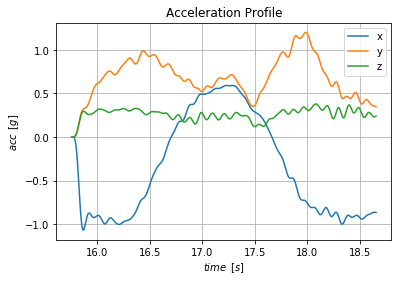

In [6]:
fmpm.plot_signal(data_filt_dict['Acc'], time=data_filt_dict['time'])

## Make a function

In [6]:
def get_data_one_rep(subject_number=1,
                     exercise_abbreviation='RF',
                     number_repetitions=5,
                     sequence_number=1,
                     db_name='DataBase_Pysio.db',
                     csv_dir='E:\Physio_Data_Split_Exercise_done',
                     sampling_rate=256,
                     cutoff=10, 
                     order=6,
                     time_offset_for_filter=0.5,
                     start_time_zero=True):
    '''
    Function to get filtered data of one certain repetition of an exercise by means of a dictionary.
    
    Inputs
    ------
    subject_number: Subject number (ID) (int)
    
    exercise_abbreviation: Abbreviation of exercise (str) (e.g. 'RF')
    
    number_repetitions: Number of repetitions (int)
    
    sequence_number: Sequence number of selected repetition (int)
    
    db_name: Name of database where repetiton info is stored (e.g. 'DataBase_Pysio.db')
    
    csv_dir: Directory where csv-files with signal data are stored
    
    sampling_rate: Sampling rate of recorded data
    
    cutoff:  Cutoff frequency for butterworth lowpass filter
    
    order: order of butterworth lowpass filter
    
    time_offset_for_filter: time offset [s] (+/-) to read data from a bigger time range for filtering
                            in order to avoid bad behaviour of the filter at the beginning and at the end;
                            if time selection is not possible try with half the time offset,
                            if this is also not possible omit the time offset
                            --> BUT: output time array is always the same (additional values are cut afterwards)
    
    start_time_zero: if True, return a time array starting at zero
    
    
    Returns
    -------
    Dictionary with filtered slected data (signals: 'Acc','Gyr','Mag','time')
    '''
    
    # Connect to an existing database
    conn = sqlite3.connect(db_name)
    cur = conn.cursor()

    # sql command to extract data
    query_sql = """
        SELECT r.start_time, r.stop_time, e.csv_file
        FROM subjects s
        INNER JOIN exercises e
        ON s.id = e.subject_id
        INNER JOIN paradigms p
        ON p.id = e.paradigm_id
        INNER JOIN repetitions r
        ON e.id = r.exercise_id
        WHERE s.id = {}
        AND p.abbreviation = '{}'
        AND e.num_rep = {}
        AND r.sequence_num = {}
        """.format(subject_number,
                   exercise_abbreviation,
                   number_repetitions,
                   sequence_number)
    
    # get data from data base and close connection
    df_data_base = pd.read_sql_query(query_sql, conn)
    conn.close()
    
    # draw csv-file name, start time and stop time from selected data
    try:
        index=0
        file_name = df_data_base['csv_file'].values[index]
        start_time = float(df_data_base['start_time'].values[index])
        stop_time = float(df_data_base['stop_time'].values[index])
    
    # if it was not possible to select data return empty dictionary
    except IndexError:
        return {}
        
    
    
    # join the path of the csv-files folder with the file name
    file_path = os.path.join(csv_dir, file_name)
    
    
    # get data from selected csv-file and seleted time range
    data_dict_with_time_offset = fmpm.get_sensor_data(in_file=file_path,
                                     signals=['Acc','Gyr','Mag'],
                                     start_time=start_time - time_offset_for_filter,
                                     stop_time=stop_time + time_offset_for_filter)
    
    # if time selection is not possible (returns empty dict) try to select with half the time offset
    if not data_dict_with_time_offset:
        time_offset_for_filter = time_offset_for_filter/2
        
        data_dict_with_time_offset = fmpm.get_sensor_data(in_file=file_path,
                                     signals=['Acc','Gyr','Mag'],
                                     start_time=start_time - time_offset_for_filter,
                                     stop_time=stop_time + time_offset_for_filter)
        
    # if this is also not possible select data without time offset
    if not data_dict_with_time_offset:
        time_offset_for_filter = 0 # needed afterwards!
        
        data_dict_with_time_offset = fmpm.get_sensor_data(in_file=file_path,
                                     signals=['Acc','Gyr','Mag'],
                                     start_time=start_time,
                                     stop_time=stop_time)
    
    
    # filter data with butterworth filter and save to new dictionary (with time offset)
    data_filt_dict_with_time_offset = {}
    for signal in ['Acc','Gyr','Mag']:
        data_filt_dict_with_time_offset[signal] = fmpm.butter_lowpass_filter(data_dict_with_time_offset[signal], 
                                                                             cutoff=cutoff, 
                                                                             fs=sampling_rate, 
                                                                             order=order)

    # calculate index offset which corresponds to the time offset
    index_offset = int(time_offset_for_filter * sampling_rate)
    
    # get corresponding data without time offset
    data_filt_dict = {}
    
    # select all if index_offset is zero
    if index_offset == 0:
        data_filt_dict['time'] = data_dict_with_time_offset['time']
        data_filt_dict['Acc'] = data_filt_dict_with_time_offset['Acc']
        data_filt_dict['Gyr'] = data_filt_dict_with_time_offset['Gyr']
        data_filt_dict['Mag'] = data_filt_dict_with_time_offset['Mag']
        
    # otherwise select data according to index_offset
    else:
        data_filt_dict['time'] = data_dict_with_time_offset['time'][index_offset:-index_offset]
        data_filt_dict['Acc'] = data_filt_dict_with_time_offset['Acc'][index_offset:-index_offset]
        data_filt_dict['Gyr'] = data_filt_dict_with_time_offset['Gyr'][index_offset:-index_offset]
        data_filt_dict['Mag'] = data_filt_dict_with_time_offset['Mag'][index_offset:-index_offset]
    
    # set start time=0 if start_time_zero is True
    if start_time_zero:
         data_filt_dict['time'] -= data_filt_dict['time'][0]
    
    # return filtered data
    return data_filt_dict

In [2]:
np.correlate([1, 2, 3], [0, 1, 0.5], "full")

array([0.5, 2. , 3.5, 3. , 0. ])

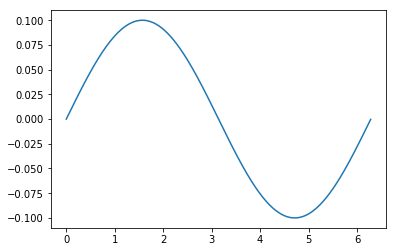

In [24]:
t_sine = np.arange(0,2*np.pi,0.01)
sine = 0.1*np.sin(t_sine)
plt.plot(t_sine, sine);

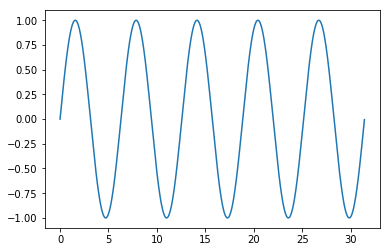

In [22]:
t_cos = np.arange(0,10*np.pi,0.01)
cosine = np.sin(t_cos)
plt.plot(t_cos, cosine);

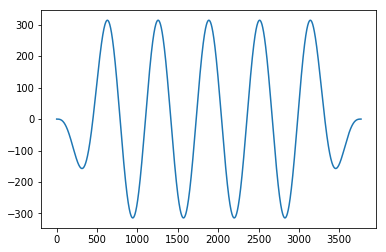

In [11]:
corr = np.correlate(cosine, sine, "full")
plt.plot(corr);

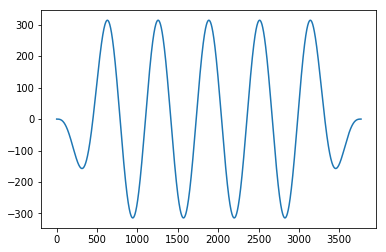

In [19]:
corr = scipy.signal.correlate(cosine, sine)
plt.plot(corr);

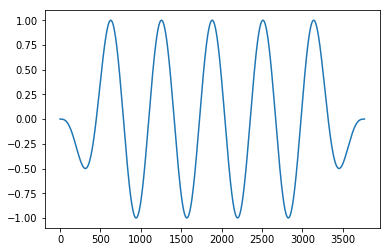

In [64]:
a, b = sine, cosine

if len(a)>len(b):
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
else:
    a = (a - np.mean(a)) / (np.std(a))
    b = (b - np.mean(b)) / (np.std(b) * len(b))


corr = scipy.signal.correlate(a, b)

plt.plot(corr);

In [21]:
def norm_cross_corr(a, b, mode='full'):
    
    if len(a)<len(b):
        a = (a - np.mean(a)) / (np.std(a) * len(a))
        b = (b - np.mean(b)) / (np.std(b))
    else:
        a = (a - np.mean(a)) / (np.std(a))
        b = (b - np.mean(b)) / (np.std(b) * len(b))

    return np.correlate(a, b, mode=mode)

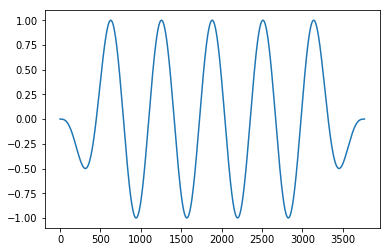

In [26]:
plt.plot(norm_cross_corr(sine, cosine));